# **PyTorch Image Classifier**
Contacts: [g.nodjoumi@jacobs-university.de](mailto:g.nodjoumi@jacobs-university.de)

A simple image classifier demo-notebook based on resnet50, to be further developed and used to filter very large dataset before labeling for object detection / image segmentation

## **Dataset**
Dataset must be organized according the following structure:
- rootdir
    - class1
        - img1
        - img2
        - imgX 
        - ...
        
### **Example**     
**E.g. data provided and used for this notebook**
- ./Example_dataset
    - Background
        - ESP_011677_1655_RED_uint8_H0_V0__crop_H0_V1__cropped_cropped.png
        - ...
    - Craters
        - ESP_011386_2065_RED_uint8_H0_V0__crop_H0_V2__cropped_cropped.png
        - ...
    - Skylights
        - ESP_061680_1985_RED_print_H2_V0__crop_cropped.png
        - ...
        
## How it works

- All images are loaded and transformed
- All images indexes are splitted into three sub-dataset indexes
    - train (used for training)
    - valid (used for validate the training)
    - test (used to simulate real-world data)
- Data distributions for sub-datasets are shown in pie charts
- Train and valid indexes are used to load images and ingest into training routine
- Plot of train/valid loss
- Test index is used to load unseen data and evaluate trained model
- For Evaluation, test data are reandomly picked and predicted

## **Import modules**

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from tqdm.auto import tqdm
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from modules.GenUtils import get_paths, question

## Data rootdir definition

In [ ]:
datadir = './DEMO-Dataset'

## Transforms definitions for train and test

In [ ]:
transform ={ 'train': transforms.Compose([transforms.Resize(900),
                                          transforms.CenterCrop(900),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomRotation([-90,90]),
                                          transforms.ToTensor(),
                                         # transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          #                     std=[0.229, 0.224, 0.225])
                                         ]),
            'test':transforms.Compose([transforms.Resize(900),
                                       transforms.CenterCrop(900),
                                          transforms.ToTensor(),
                                          #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                           #                    std=[0.229, 0.224, 0.225])
                                      ]),
            }

Load of full dataset and retrevial of image indeses and classes from dataset

In [ ]:
image_dataset = datasets.ImageFolder(datadir, transform=transform['train'])

num_train = len(image_dataset)
indices = list(range(num_train))
print('Dataset contains:', len(image_dataset), ' elements distributed in: ',image_dataset.classes)

## Creation of indexes

In [ ]:
start = time.time()
ts, clss = map(list,zip(*image_dataset))
end = time.time()
print(end - start)

In [ ]:
columns = ['class','type']
DF = pd.DataFrame(columns=columns)
DF['class']=clss
classes = image_dataset.classes

In [ ]:
train_idx, test_idx = train_test_split(indices,
                                          test_size=0.05,
                                          shuffle=True,
                                          stratify=DF['class'].values,
                                          #stratify=DF['type'].values,
                                          random_state=0)

Train_idx is further divided in proper train and valid indexes

In [ ]:
train_idx, valid_idx = train_test_split(train_idx,
                                          test_size=0.3,
                                          shuffle=True,
                                          stratify=DF['class'].loc[train_idx],
                                          #stratify=DF.loc[train_data],
                                          random_state=0)

Train and Valid data loading

In [ ]:
trainloader = torch.utils.data.DataLoader(image_dataset,
               sampler=train_idx, batch_size=8,pin_memory=True)
validloader = torch.utils.data.DataLoader(image_dataset,
               sampler=valid_idx, batch_size=8,pin_memory=True)

In [ ]:
DF.loc[train_idx,'type']='TRAIN'
DF.loc[test_idx,'type']='TEST'
DF.loc[valid_idx,'type']='VALID'

Plot of data distribution

In [ ]:
label = classes
plt.figure(figsize = (20,10), facecolor='white',dpi=300)

plt.suptitle('Data distributions', fontsize=15)
ax1 = plt.subplot2grid((1,3),(0,0))
plt.pie(DF.loc[DF['type'] == 'TRAIN'].groupby('class').size(),
        labels=label,autopct=lambda p:f'{p:.2f}%, \n{p*len(train_idx)/100:.0f} Images',
        shadow=False, startangle=90)
plt.title('Train Data\n{} Images'.format(len(train_idx), loc='center'))
ax1 = plt.subplot2grid((1,3),(0,1))
plt.pie(DF.loc[DF['type'] == 'VALID'].groupby('class').size(), 
        labels=label,autopct=lambda p:f'{p:.2f}%, \n{p*len(valid_idx)/100:.0f} Images', 
        shadow=False, startangle=90)
plt.title('Valid Data\n{} Images'.format(len(valid_idx), loc='center'))
ax1 = plt.subplot2grid((1,3),(0,2))
plt.pie(DF.loc[DF['type'] == 'TEST'].groupby('class').size(), 
        labels=label,autopct=lambda p:f'{p:.2f}%, \n{p*len(test_idx)/100:.0f} Images', 
        shadow=False, startangle=90)
plt.title('Test Data\n{} Images'.format(len(test_idx), loc='center'))

plt.tight_layout()
plt.show()

In [ ]:
def save_model(model):
    from datetime import datetime
    now = datetime.now()
    dt_string = now.strftime("%d%m%Y@%H%M%S")
    model_name = 'Pretrained_models/Trained_'+dt_string+'.pth'
    torch.save(model, model_name)

In [ ]:
def plot_train_valid_loss(train_losses, valid_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()

In [ ]:
def train_prep():
    #Check Device to use
    device = torch.device("cuda" if torch.cuda.is_available() 


                          else "cpu")

    #Load the default model
    preT = True
    model = models.resnet50(pretrained=True)
    #print(model)

    #Freeze the default pretrained layers if selected
    if preT == True:
        for param in model.parameters():
            param.requires_grad = False

    #Define the last fully connected layer
    model.fc = nn.Sequential(nn.Linear(2048, 512),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(512, 10),
                                     nn.LogSoftmax(dim=1))

    #Define loss criteria and otpimization function
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

    #Send the model to the device
    model.to(device)
    return model, device, criterion, optimizer

In [ ]:
def train():
    model, device, criterion, optimizer= train_prep()
    epochs = 1
    steps = 0
    running_loss = 0
    print_every = 10
    train_losses =  []
    valid_losses = []

    for epoch in range(epochs):

        for inputs, labels in trainloader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if steps % print_every == 0:
                valid_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in validloader:
                        inputs, labels = inputs.to(device),labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                        valid_loss += batch_loss.item()

                       # ps = torch.exp(logps)
                        #top_p, top_class = ps.topk(1, dim=1)
                        #equals = top_class == labels.view(*top_class.shape)
                        #accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                valid_losses.append(valid_loss/len(validloader))                    
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Valid loss: {valid_loss/len(validloader):.3f}.. ")
                      #f"Valid accuracy: {accuracy/len(validloader):.3f}")
                running_loss = 0
                model.train()
    plot_train_valid_loss(train_losses, valid_losses)
    model_name = save_model(model)
    return model, model_name, device

In [ ]:
def accuracy(dataloader, device):
        # tracking test loss
    test_loss = 0.0
    cls_correct = list(0. for i in range(len(classes)))
    cls_totals = list(0. for i in range(len(classes)))

    criterion = nn.NLLLoss()
    
    model.eval()  # it-disables-dropout
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()*images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_ts = predicted.eq(labels.data.view_as(predicted))
            correct = np.squeeze(correct_ts.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_ts.cpu().numpy())
            for i in range(len(labels)):
                label = labels.data[i]
                cls_correct[label] += correct[i].item()
                cls_totals[label] += 1
        test_loss = test_loss/len(dataloader.dataset)

        print(f'Test Loss: {round(test_loss, 6)}')

        for i in range(len(classes)):
            if cls_totals[i] > 0:
                print(f'Accuracy of {classes[i]}: {round(100*cls_correct[i]/cls_totals[i], 2)}%')
            else:
                print(f'Accuracy of {classes[i]}s: N/A (no training examples)')


    print(f'Full Accuracy: {round(100. * np.sum(cls_correct) / np.sum(cls_totals), 2)}% {np.sum(cls_correct)} out of {np.sum(cls_totals)}')

    # Save 
    #torch.save(model.state_dict(), 'model.ckpt')

## **Training**

In [ ]:
q = question('Train from scracth?: ', ['Y','y','N','n'])

In [ ]:
model_name = None

In [ ]:
if q in ['Y','y']:
    model, model_name, device= train()
    accuracy(validloader, device)

In [41]:
model_name

'Pretrained_models/pretrained_model.pth'

## **Testing**
Loading model for testing on test dataset

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model=torch.load('./pretraiend_models/pre_trained_model.pth')
if model_name == None:
    print('No new model found... Loading default model.')
    model_name = 'Pretrained_models/pretrained_model.pth'
    model=torch.load('./'+model_name)
model.eval()

### **Definition of functions**
Prediction function

In [34]:
def predict_image(image):
    image_tensor = transform['test'](image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

Function to get random images from test dataset using test indexs

In [35]:
def get_random_images(num, indice,test_dataset):
    idx=np.random.choice(indice,num)
    loader = torch.utils.data.DataLoader(test_dataset, 
                   sampler=idx, batch_size=num,pin_memory=True)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, idx, loader

Loading of all images using test transform

In [36]:
test_dataset = datasets.ImageFolder(datadir, transform=transform['test'])

Prediction and plotting

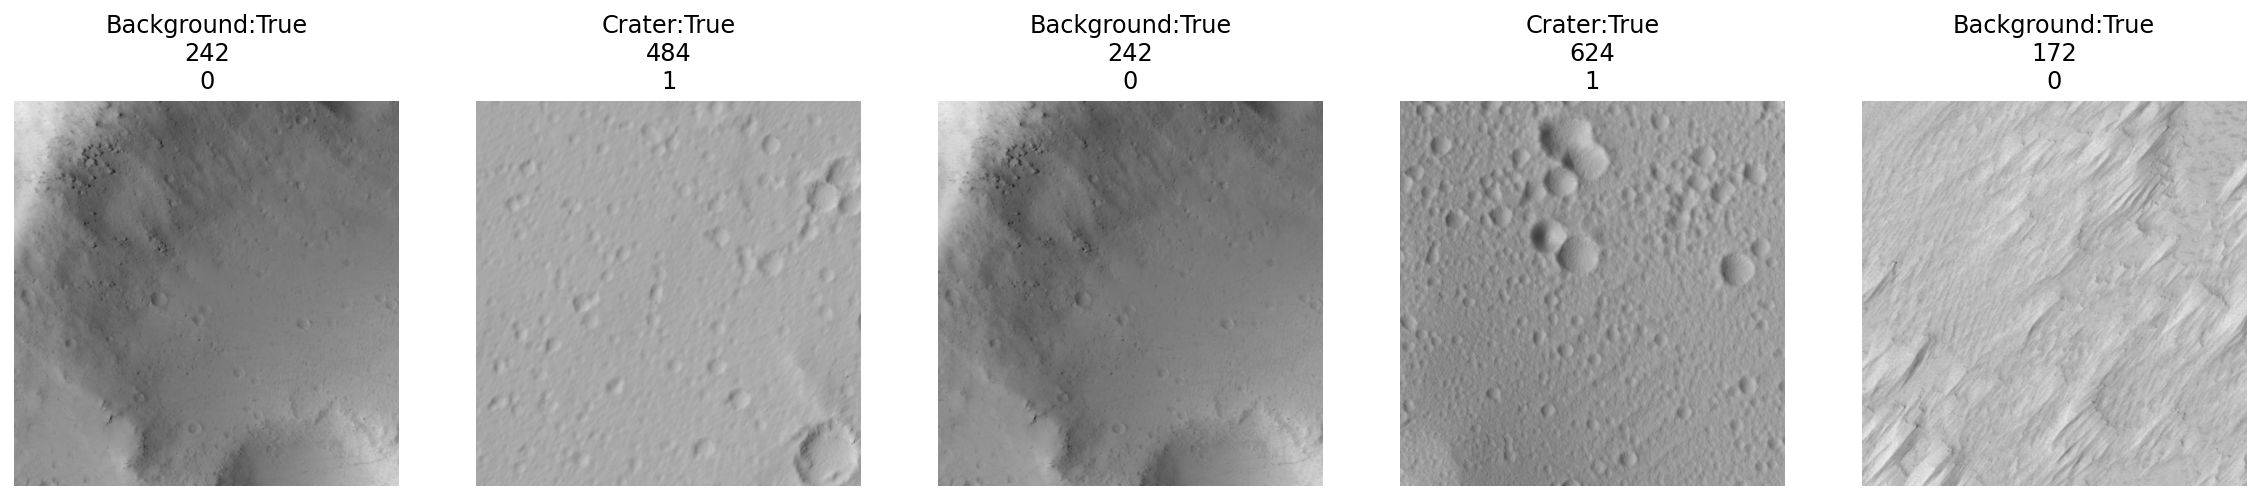

In [37]:
to_pil = transforms.ToPILImage()
images, labels, idx, testloader= get_random_images(5, test_idx,test_dataset)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
#    sub.set_title(str(classes[index]) + ":" + str(res))
    sub.set_title(str(classes[index]) + ":" + str(res)+'\n'+str(idx[ii])+'\n'+str(index))

    plt.axis('off')
    #r_img = to_pil(test_data[ii][0])
    plt.imshow(image)
plt.show()

Check accuracy of predictions

In [39]:
accuracy(testloader, device)

Test Loss: 0.001375
Accuracy of Background: 100.0%
Accuracy of Crater: 100.0%
Accuracy of Skylights: N/A (no training examples)
Full Accuracy: 100.0% 5.0 out of 5.0


Final check to verify that test images have not been used for training

In [ ]:
for i in idx:
    if i in train_idx:
        print(i, ' has been used in training')
    else:
        print(i, ' has not been used in training')